## Problem Statement: 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Currently, under 30% of subway stations are fully accessible via elevator or ramp. Besides the static need from population with disabilities, NYC, like most cities in the world, is facing a population that's aging beyond the pace of facilities support: by year 2040, over 40% of the city's residents will be over the age of 65. The city pledge to acheive 95% accessiblity by year 2055, but it's an expensive endeavor, taking up to 15% of its annual budget. We hope to identify subway stations that should be prioritized for an upgrade.


Sources:
https://www.nytimes.com/2022/06/22/nyregion/nyc-subway-accessibility-disabilities-elevators.html 

https://new.mta.info/project/station-accessibility-upgrades 

https://new.mta.info/accessibility/selecting-subway-stations-for-upgrades

## Part I: Setting Up

In [374]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import matplotlib.pyplot as plt
import plotly.express as px

from datetime import datetime

from sklearn.cluster import KMeans
import seaborn as sns
from scipy.spatial import distance

import pandas as pd
import json
import requests
from shapely.geometry import Point, shape
import shapefile

import censusgeocode as cg

import shapefile  # PyShp library
import pandas as pd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

### Getting and storing MTA data

In [ ]:
def get_data(api_url,limit):
    offset = 0
    all_data = pd.DataFrame()
    
    
    while True:
        response = requests.get(api_url, f"$limit={limit}&$offset={offset}")
        data = pd.read_csv(StringIO(response.text))
        
        if data.empty:
            break
        
        all_data = pd.concat([all_data, data], ignore_index=True)
        offset += limit
    return all_data

In [2]:
### DO NOT RUN
### Download MTA Data (takes a while, use cell below to load data instead) 
#https://catalog.data.gov/dataset/mta-subway-stations-and-complexes 
#df_stations = pd.read_csv('./data/MTA_Subway_Stations_and_Complexes.csv')
response_stations = requests.get("https://data.ny.gov/resource/5f5g-n3cz.csv")
df_stations = pd.read_csv(StringIO(response_stations.text))

#https://data.ny.gov/Transportation/MTA-Subway-Entrances-and-Exits-2024/i9wp-a4ja/about_data  
# df_entrance_exit = pd.read_csv('./data/MTA_Subway_Entrances_and_Exits__2024_20241116.csv')
response_entrance = requests.get("https://data.ny.gov/resource/i9wp-a4ja.csv")
df_entrance_exit = pd.read_csv(StringIO(response_entrance.text))


# https://data.ny.gov/Transportation/MTA-Subway-Origin-Destination-Ridership-Estimate-2/jsu2-fbtj/about_data (API default 1000/call, ~71M rows) most recent 2024
response_route = requests.get("https://data.ny.gov/resource/jsu2-fbtj.csv", "$limit=80000000")
df_route_2024 = pd.read_csv(StringIO(response_ridership.text))

# https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-Beginning-July-2020/wujg-7c2s/about_data (API default 1000/call, ~105M rows) July 2020 - Oct 2024
response_ridership = requests.get("https://data.ny.gov/resource/wujg-7c2s.csv", "$limit=200000000")
df_ridership = pd.read_csv(StringIO(response_ridership.text))


df_stations.to_csv('stations.cvs')
df_entrance_exit.to_csv('entraces_and_exits.csv')
df_route_2024.to_csv('origin_destination_2024.csv')
df_ridershio.to_csv('ridership.csv')

In [2]:
### Use this cell to read raw MTA Data(takes a while) 
### For analysis, read the summary dfs at the end of preprocessing section instead

df_stations = pd.read_csv('stations.csv')
df_entrance_exit = pd.read_csv('entraces_and_exits.csv',index_col = 'Unnamed: 0')
df_route_2024 = pd.read_csv('origin_destination_2024.csv')
df_ridership = pd.read_csv('ridership.csv')

/var/folders/qv/1bnh64t16cnc1ftltf9q3y6c0000gn/T/ipykernel_39539/3278684803.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ridership = pd.read_csv('ridership.csv')


### Getting and storing Census data

In [3]:
### function to query census data from API
### avaiable datasets and query format: https://www.census.gov/data/developers/guidance/api-user-guide.Example_API_Queries.html
### american community survey api format: https://api.census.gov/data/2022/acs/acs5/examples.html

with open("api_key.txt", 'r') as file:
    api_key = file.read().strip()
    
def fetch_census_data(api_key, variables, state, county, dataset="acs/acs5/subject"):
    """
    get Census data from the specified dataset and geography
    Input:
        api_key: variable holding API key
        variables: List of variable codes to retrieve.
        state: state code 
        dataset: The dataset to use (default: "acs/acs5/subject")

    Output:
        DataFrame of queried data
    """
    ## API examples
    # https://api.census.gov/data/2022/acs/acs5?get=NAME,B01001_001E&for=tract:018700&in=state:06%20county:073&key=YOUR_KEY_GOES_HERE
    # https://api.census.gov/data/2022/acs/acs5/subject?get=NAME,S0101_C01_001E&for=tract:018700&in=state:06%20county:073&key=YOUR_KEY_GOES_HERE
    
    base_url = f"https://api.census.gov/data/2022/{dataset}"  ## include "/subject" for S-tables; remove for B-tables
    variables_str = ",".join(variables)
    
    url = (f"{base_url}?get=NAME,{variables_str}&for=tract:*&in=state:{state}%20county:{county}&key={api_key}")
    print(url)
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        columns = data[0]
        values = data[1:]
        df = pd.DataFrame(values, columns=columns)
        return df
    else:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")



In [4]:
variables_subject = [
        "S1810_C01_001E",  # Total population for whom disability status is determined
        "S1810_C02_001E",  # Total population with a disability
        "S1810_C02_003E",  # Population 18–64 years with a disability
        "S1810_C02_004E",  # Population 65 years and over with a disability
        "S1810_C03_001E",  # Employed population with a disability (18–64)
        "S0101_C01_001E",  # Total population
        "S0101_C02_030E",  # Population 55-59
        "S0101_C02_031E",  # Population 60-64
        "S0101_C01_030E", # Population 65 and over
        "S0101_C01_034E", # Age Dependency Ratio
        "S0801_C01_001E",  # Total workers 16 years and over
        "S0801_C01_002E",  # Car, truck, or van - drove alone
        "S0801_C01_004E",  # Public transportation (excluding taxicab)
        "S1901_C01_001E",  # Median household income
        "S1901_C01_002E",  # Mean household income
        "S1902_C01_002E",  # Percentage of households below poverty level
        "S1902_C01_003E",  # Percentage of households with income over $200k

    ]

variables_detail = ["B01001_001E",    # Total population
        "B01002_001E",    # Median age
        "B11004_004E",  # Households with children under 6 years
        "B11004_010E",  # Households with children 6 to 17 years
        "B08101_049E",  # Workers 16 years and over using public transportation
    ]

data_manhattan_1 = fetch_census_data(api_key, variables_subject, state="36", county="061", dataset="acs/acs5/subject")
data_bronx_1 = fetch_census_data(api_key, variables_subject, state="36", county="005", dataset="acs/acs5/subject")
data_bklyn_1 = fetch_census_data(api_key, variables_subject, state="36", county="047", dataset="acs/acs5/subject")
data_queens_1 = fetch_census_data(api_key, variables_subject, state="36", county="081", dataset="acs/acs5/subject")
data_si_1 = fetch_census_data(api_key, variables_subject, state="36", county="085", dataset="acs/acs5/subject")

data_manhattan_2 = fetch_census_data(api_key, variables_detail, state="36", county="061", dataset="acs/acs5")
data_bronx_2 = fetch_census_data(api_key, variables_detail, state="36", county="005", dataset="acs/acs5")
data_bklyn_2 = fetch_census_data(api_key, variables_detail, state="36", county="047", dataset="acs/acs5")
data_queens_2 = fetch_census_data(api_key, variables_detail, state="36", county="081", dataset="acs/acs5")
data_si_2 = fetch_census_data(api_key, variables_detail, state="36", county="085", dataset="acs/acs5")

### join two tables for each borough
data_manhattan_final = pd.merge(data_manhattan_1,data_manhattan_2, how = 'outer', left_on = ['state','county','tract'], right_on = ['state', 'county','tract'])
data_bklyn_final = pd.merge(data_bklyn_1,data_bklyn_2, how = 'outer', left_on = ['state','county','tract'], right_on = ['state', 'county','tract'])
data_bronx_final = pd.merge(data_bronx_1,data_bronx_2, how = 'outer', left_on = ['state','county','tract'], right_on = ['state', 'county','tract'])
data_queens_final = pd.merge(data_queens_1,data_queens_2, how = 'outer', left_on = ['state','county','tract'], right_on = ['state', 'county','tract'])
data_si_final = pd.merge(data_si_1,data_si_2, how = 'outer', left_on = ['state','county','tract'], right_on = ['state', 'county','tract'])

### concat all boroughs
data_nyc_final = [data_manhattan_final, data_bklyn_final, data_bronx_final , data_queens_final, data_si_final]
df_nyc_final_concat = pd.concat(data_nyc_final, ignore_index=True)

### rename columns to be readable
df_nyc_final_concat.columns

col_dict = {
    "S1810_C01_001E": "Total population for whom disability status is determined",
    "S1810_C02_001E": "Total population with a disability",
    "S1810_C02_003E": "Population 18–64 years with a disability",
    "S1810_C02_004E": "Population 65 years and over with a disability",
    "S1810_C03_001E": "Employed population with a disability (18–64)",
    "S0101_C01_001E": "Total population",
    "S0101_C02_030E": "Population 55-59",
    "S0101_C02_031E": "Population 60-64",
    "S0101_C01_030E": "Population 65 and over",##
    "S0101_C01_034E": "Age Dependency Ratio", ##
    "S0801_C01_001E": "Total workers 16 years and over",
    "S0801_C01_002E": "Car, truck, or van - drove alone",
    "S0801_C01_004E": "Public transportation (excluding taxicab)",
    "S1901_C01_001E": "Median household income",
    "S1901_C01_002E": "Mean household income",
    "S1902_C01_002E": "Percentage of households below poverty level",
    "S1902_C01_003E": "Percentage of households with income over $200k",
    "S0101_C02_034E":"Age dependency ratio",
    "B01001_001E": "Total population",
    "B01002_001E": "Median age",
    "B11004_004E": "Households with children under 6 years",
    "B11004_010E": "Households with children 6 to 17 years",
    "B08101_049E": "Workers 16 years and over using public transportation"}
df_nyc_final_concat.rename(columns= col_dict, inplace=True)
df_nyc_final_concat.drop('NAME_y', axis=1, inplace=True)
df_nyc_final_concat.to_csv('census_nyc.csv')


https://api.census.gov/data/2022/acs/acs5/subject?get=NAME,S1810_C01_001E,S1810_C02_001E,S1810_C02_003E,S1810_C02_004E,S1810_C03_001E,S0101_C01_001E,S0101_C02_030E,S0101_C02_031E,S0101_C01_030E,S0101_C01_034E,S0801_C01_001E,S0801_C01_002E,S0801_C01_004E,S1901_C01_001E,S1901_C01_002E,S1902_C01_002E,S1902_C01_003E&for=tract:*&in=state:36%20county:061&key=422f1975d9bff904246e69ded2462fdf78ab5829
https://api.census.gov/data/2022/acs/acs5/subject?get=NAME,S1810_C01_001E,S1810_C02_001E,S1810_C02_003E,S1810_C02_004E,S1810_C03_001E,S0101_C01_001E,S0101_C02_030E,S0101_C02_031E,S0101_C01_030E,S0101_C01_034E,S0801_C01_001E,S0801_C01_002E,S0801_C01_004E,S1901_C01_001E,S1901_C01_002E,S1902_C01_002E,S1902_C01_003E&for=tract:*&in=state:36%20county:005&key=422f1975d9bff904246e69ded2462fdf78ab5829
https://api.census.gov/data/2022/acs/acs5/subject?get=NAME,S1810_C01_001E,S1810_C02_001E,S1810_C02_003E,S1810_C02_004E,S1810_C03_001E,S0101_C01_001E,S0101_C02_030E,S0101_C02_031E,S0101_C01_030E,S0101_C01_034E

## Part II: Data Preprocessing

#### Examine datasets and extract relevant information

In [5]:
print(df_stations.shape)
print(len(df_stations['GTFS Stop IDs'].unique())) ## Unique ID for each station
df_stations.head()

(445, 16)
445


Complex ID  Is Complex  Number Of Stations In Complex  \
0           1       False                              1   
1           2       False                              1   
2           3       False                              1   
3           4       False                              1   
4           5       False                              1   

              Stop Name                Display Name Constituent Station Names  \
0  Astoria-Ditmars Blvd  Astoria-Ditmars Blvd (N W)      Astoria-Ditmars Blvd   
1          Astoria Blvd          Astoria Blvd (N W)              Astoria Blvd   
2                 30 Av                 30 Av (N W)                     30 Av   
3              Broadway              Broadway (N W)                  Broadway   
4                 36 Av                 36 Av (N W)                     36 Av   

  Station IDs GTFS Stop IDs Borough    CBD Daytime Routes Structure Type  \
0           1           R01       Q  False            N W       Elevated   
1           2           R03       Q  False            N W       Elevated   
2           3           R04       Q  False            N W       Elevated   
3           4           R05       Q  False            N W       Elevated   
4           5           R06       Q  False            N W       Elevated   

    Latitude  Longitude  ADA ADA Notes  
0  40.775036 -73.912034    0       NaN  
1  40.770258 -73.917843    1       NaN  
2  40.766779 -73.921479    0       NaN  
3  40.761820 -73.925508    0       NaN  
4  40.756804 -73.929575    0       NaN

We are interested in the ADA column, indicating if a station is compliant to Americans with Disabilities Act, 
* 1=fully accessible
* 0=not accessible
* 2=partially accessible, e.g. only accessible for one direction</br>

To start, we'll focus on the not accessible stations. The entrance and exit dataset below have more detailed information for each stops in case we want to consider the directions of the train, and the type of entrance (e.g. stairs, elevator, ramp, ..).

In [7]:
df_entrance_exit.head()

division    line borough                 stop_name  complex_id  \
0      BMT  4th Av       B  Atlantic Av-Barclays Ctr         617   
1      BMT  4th Av       B  Atlantic Av-Barclays Ctr         617   
2      BMT  4th Av       B  Atlantic Av-Barclays Ctr         617   
3      BMT  4th Av       B                  Union St          28   
4      BMT  4th Av       B                  Union St          28   

   constituent_station_name  station_id gtfs_stop_id     daytime_routes  \
0  Atlantic Av-Barclays Ctr          27          R31  2 3 4 5 B D N Q R   
1  Atlantic Av-Barclays Ctr          27          R31  2 3 4 5 B D N Q R   
2  Atlantic Av-Barclays Ctr          27          R31  2 3 4 5 B D N Q R   
3                  Union St          28          R32                  R   
4                  Union St          28          R32                  R   

  entrance_type entry_allowed exit_allowed  entrance_latitude  \
0         Stair           YES          YES          40.683905   
1      Elevator           YES          YES          40.683805   
2         Stair           YES          YES          40.683928   
3         Stair           YES          YES          40.677154   
4         Stair           YES          YES          40.677296   

   entrance_longitude           entrance_georeference  
0          -73.978879    POINT (-73.978879 40.683905)  
1          -73.978487    POINT (-73.978487 40.683805)  
2          -73.978412    POINT (-73.978412 40.683928)  
3          -73.983430  POINT (-73.9834296 40.6771544)  
4          -73.983336  POINT (-73.9833364 40.6772958)

In [33]:
len(df_entrance_exi.unique())

185

Ridership data is what we are interested in, but it only holds data for each complex which can contrain serveral stations. For this dataset, we want to get the number of riders using the senior or disability card and merge with.

In [8]:
df_ridership.head()

transit_timestamp transit_mode station_complex_id  \
0  12/14/2020 06:00:00 AM       subway                619   
1  12/14/2020 04:00:00 AM       subway                 69   
2  12/14/2020 05:00:00 PM       subway                127   
3  12/14/2020 07:00:00 AM       subway                396   
4  12/14/2020 08:00:00 PM       subway                  3   

                                   station_complex    borough payment_method  \
0  Broadway-Lafayette St (B,D,F,M)/Bleecker St (6)  Manhattan      metrocard   
1                                        25 Av (D)   Brooklyn      metrocard   
2                                    DeKalb Av (L)   Brooklyn           omny   
3                                        96 St (6)  Manhattan      metrocard   
4                                      30 Av (N,W)     Queens      metrocard   

           fare_class_category  ridership  transfers   latitude  longitude  \
0  Metrocard - Unlimited 7-Day         13          0  40.725914  -73.99466   
1        Metrocard - Full Fare         13          0  40.597706  -73.98683   
2             OMNY - Full Fare         29          0  40.703810  -73.91843   
3        Metrocard - Fair Fare          6          0  40.785670  -73.95107   
4  Metrocard - Unlimited 7-Day         24          0  40.766780  -73.92148   

                  Georeference  
0  POINT (-73.99466 40.725914)  
1  POINT (-73.98683 40.597706)  
2   POINT (-73.91843 40.70381)  
3   POINT (-73.95107 40.78567)  
4   POINT (-73.92148 40.76678)

In [78]:
df_ridership['fare_class_category'].unique()

array(['Metrocard - Unlimited 7-Day', 'Metrocard - Full Fare',
       'OMNY - Full Fare', 'Metrocard - Fair Fare',
       'Metrocard - Unlimited 30-Day', 'Metrocard - Students',
       'Metrocard - Seniors & Disability', 'Metrocard - Other',
       'OMNY - Other', 'OMNY - Seniors & Disability', 'OMNY - Students',
       'OMNY - Fair Fare'], dtype=object)

In [79]:
# since the dataset is large, we want to only keep the senior and disablity swipes and work with df_route instead for general ridership
df_ridership_dis = df_ridership[df_ridership['fare_class_category'].isin(['Metrocard - Seniors & Disability', 'OMNY - Seniors & Disability'])]


In [87]:
len(df_ridership_dis['station_complex_id'].unique())

854

In [85]:
df_ridership_dis

transit_timestamp transit_mode station_complex_id  \
11         12/14/2020 05:00:00 AM       subway                 99   
18         12/14/2020 10:00:00 AM       subway                123   
26         12/14/2020 09:00:00 PM       subway                636   
47         12/14/2020 05:00:00 AM       subway                242   
52         12/14/2020 01:00:00 PM       subway                 91   
...                           ...          ...                ...   
105476397  12/14/2020 07:00:00 AM       subway                 67   
105476404  12/14/2020 09:00:00 PM       subway                156   
105476407  12/14/2020 11:00:00 AM       subway                 88   
105476408  12/14/2020 04:00:00 AM       subway                189   
105476412  12/14/2020 09:00:00 PM       subway                628   

                       station_complex    borough payment_method  \
11                    Lorimer St (M,J)   Brooklyn      metrocard   
18                        Grand St (L)   Brooklyn      metrocard   
26          Jay St-MetroTech (A,C,F,R)   Brooklyn      metrocard   
47            Fort Hamilton Pkwy (F,G)   Brooklyn      metrocard   
52                      Alabama Av (J)   Brooklyn      metrocard   
...                                ...        ...            ...   
105476397                    20 Av (D)   Brooklyn      metrocard   
105476404                 103 St (C,B)  Manhattan      metrocard   
105476407             Norwood Av (J,Z)   Brooklyn      metrocard   
105476408                 Grant Av (A)   Brooklyn      metrocard   
105476412  Fulton St (A,C,J,Z,2,3,4,5)  Manhattan      metrocard   

                        fare_class_category  ridership  transfers   latitude  \
11         Metrocard - Seniors & Disability          4          0  40.703870   
18         Metrocard - Seniors & Disability          5          2  40.711926   
26         Metrocard - Seniors & Disability          3          2  40.692337   
47         Metrocard - Seniors & Disability          3          0  40.650784   
52         Metrocard - Seniors & Disability          1          1  40.676990   
...                                     ...        ...        ...        ...   
105476397  Metrocard - Seniors & Disability          9          0  40.604557   
105476404  Metrocard - Seniors & Disability          3          0  40.796093   
105476407  Metrocard - Seniors & Disability          3          0  40.681410   
105476408  Metrocard - Seniors & Disability          1          0  40.677044   
105476412  Metrocard - Seniors & Disability          3          0  40.710370   

           longitude                 Georeference  
11        -73.947410   POINT (-73.94741 40.70387)  
18        -73.940670  POINT (-73.94067 40.711926)  
26        -73.987340  POINT (-73.98734 40.692337)  
47        -73.975780  POINT (-73.97578 40.650784)  
52        -73.898650   POINT (-73.89865 40.67699)  
...              ...                          ...  
105476397 -73.998170  POINT (-73.99817 40.604557)  
105476404 -73.961460  POINT (-73.96146 40.796093)  
105476407 -73.880035  POINT (-73.880035 40.68141)  
105476408 -73.865050  POINT (-73.86505 40.677044)  
105476412 -74.007690   POINT (-74.00769 40.71037)  

[13702356 rows x 12 columns]

In [553]:
print(df_route_2024['Month'].describe())
df_route_2024.head()

count    7.629451e+07
mean     4.512849e+00
std      2.266179e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      6.000000e+00
max      8.000000e+00
Name: Month, dtype: float64


Year  Month Day of Week  Hour of Day               Timestamp  \
0  2024      7      Sunday            7  07/14/2024 07:00:00 AM   
1  2024      7      Sunday            7  07/14/2024 07:00:00 AM   
2  2024      7      Sunday            7  07/14/2024 07:00:00 AM   
3  2024      7      Sunday            7  07/14/2024 07:00:00 AM   
4  2024      7      Sunday            7  07/14/2024 07:00:00 AM   

   Origin Station Complex ID       Origin Station Complex Name  \
0                        167    W 4 St-Wash Sq (A,C,E,B,D,F,M)   
1                        192                 Rockaway Blvd (A)   
2                        204                   Beach 67 St (A)   
3                        256                  Parsons Blvd (F)   
4                        602  14 St-Union Sq (L,N,Q,R,W,4,5,6)   

   Origin Latitude  Origin Longitude  Destination Station Complex ID  \
0        40.732338        -74.000495                              66   
1        40.680429        -73.843853                             391   
2        40.590927        -73.796924                             164   
3        40.707564        -73.803326                             602   
4        40.735066        -73.990416                             436   

   Destination Station Complex Name  Destination Latitude  \
0                         18 Av (D)             40.607954   
1      138 St-Grand Concourse (4,5)             40.813224   
2        34 St-Penn Station (A,C,E)             40.752287   
3  14 St-Union Sq (L,N,Q,R,W,4,5,6)             40.735066   
4                 Harlem-148 St (3)             40.823880   

   Destination Longitude  Estimated Average Ridership  \
0             -74.001736                       0.3250   
1             -73.929849                       0.3022   
2             -73.993391                       0.9045   
3             -73.990416                       0.3593   
4             -73.936470                       0.6293   

                   Origin Point             Destination Point  
0  POINT (-74.000495 40.732338)  POINT (-74.001736 40.607954)  
1  POINT (-73.843853 40.680429)  POINT (-73.929849 40.813224)  
2  POINT (-73.796924 40.590927)  POINT (-73.993391 40.752287)  
3  POINT (-73.803326 40.707564)  POINT (-73.990416 40.735066)  
4  POINT (-73.990416 40.735066)    POINT (-73.93647 40.82388)

In [33]:
df_nyc_final_concat.head()
### notice some negative values when population is 0

NAME_x  \
0     Census Tract 1; New York County; New York   
1  Census Tract 2.01; New York County; New York   
2  Census Tract 2.02; New York County; New York   
3     Census Tract 5; New York County; New York   
4     Census Tract 6; New York County; New York   

  Total population for whom disability status is determined  \
0                                                  0          
1                                               2621          
2                                               6991          
3                                                  0          
4                                              10575          

  Total population with a disability Population 18–64 years with a disability  \
0                                  0                                        0   
1                                248                                      114   
2                               1064                                      523   
3                                  0                                        0   
4                               1516                                      866   

  Population 65 years and over with a disability  \
0                                              0   
1                                             45   
2                                            550   
3                                              0   
4                                            133   

  Employed population with a disability (18–64) Total population  \
0                                  -666666666.0                0   
1                                           9.5             2666   
2                                          15.2             7001   
3                                  -666666666.0                0   
4                                          14.3            10751   

  Population 55-59 Population 60-64 Population 65 and over  ...  \
0     -666666666.0     -666666666.0                      0  ...   
1             12.3              5.6                    328  ...   
2             18.2              5.6                   1275  ...   
3     -666666666.0     -666666666.0                      0  ...   
4             31.1             17.4                   3340  ...   

  Percentage of households below poverty level  \
0                                            0   
1                                          482   
2                                         1760   
3                                            0   
4                                         2547   

  Percentage of households with income over $200k state county   tract  \
0                                               0    36    061  000100   
1                                             443    36    061  000201   
2                                            1669    36    061  000202   
3                                               0    36    061  000500   
4                                            2372    36    061  000600   

  Total population    Median age Households with children under 6 years  \
0                0  -666666666.0                                      0   
1             2666          25.9                                     24   
2             7001          47.4                                     22   
3                0  -666666666.0                                      0   
4            10751          51.2                                      0   

  Households with children 6 to 17 years  \
0                                      0   
1                                     46   
2                                      0   
3                                      0   
4                                     39   

  Workers 16 years and over using public transportation  
0                                                  0     
1                                                146     
2                                                821     
3                                                

We want to associate socio-economic status with each station. 


In [554]:
def match_latlong_to_tract(lat, lon, shapefile_path):
    """
    Matches latitude and longitude to a census tract using a shapefile.
    """
    # Open shapefile containing census tracts
    sf = shapefile.Reader(shapefile_path)
    
    # Loop through each shape in the shapefile
    for shape_record in sf.shapeRecords():
        # Create a Polygon object from the shapefile shape (geometry)
        polygon = Polygon(shape_record.shape.points)
        
        # Create a Shapely Point object for the lat/long coordinates
        point = Point(lon, lat)
        
        # Check if the point is inside the polygon (tract boundary)
        if polygon.contains(point):
            # If the point is inside the tract, return the GEOID (census tract ID)
            return shape_record.record['GEOID']
    
    return None  # Return None if no match found

def append_census_info(df, lat_col, lon_col, shapefile_path):
    """
    Append census tract information to the dataframe based on lat/lon columns.
    """
    census_tracts = []
    
    # Iterate through each row in the DataFrame
    for _, row in df.iterrows():
        lat = row[lat_col]
        lon = row[lon_col]
        
        # Get the census tract for this lat/long
        tract = match_latlong_to_tract(lat, lon, shapefile_path)
        census_tracts.append(tract)
    
    # Add the census tract information as a new column in the DataFrame
    df['CensusTract'] = census_tracts
    
    return df





In [247]:
shapefile_path = "tl_2022_36_tract.shp"

df_with_census = append_census_info(df_stations, 'Latitude', 'Longitude', shapefile_path)


In [251]:
df_with_census.head()

Complex ID  Is Complex  Number Of Stations In Complex  \
0           1       False                              1   
1           2       False                              1   
2           3       False                              1   
3           4       False                              1   
4           5       False                              1   

              Stop Name                Display Name Constituent Station Names  \
0  Astoria-Ditmars Blvd  Astoria-Ditmars Blvd (N W)      Astoria-Ditmars Blvd   
1          Astoria Blvd          Astoria Blvd (N W)              Astoria Blvd   
2                 30 Av                 30 Av (N W)                     30 Av   
3              Broadway              Broadway (N W)                  Broadway   
4                 36 Av                 36 Av (N W)                     36 Av   

  Station IDs GTFS Stop IDs Borough    CBD Daytime Routes Structure Type  \
0           1           R01       Q  False            N W       Elevated   
1           2           R03       Q  False            N W       Elevated   
2           3           R04       Q  False            N W       Elevated   
3           4           R05       Q  False            N W       Elevated   
4           5           R06       Q  False            N W       Elevated   

    Latitude  Longitude  ADA ADA Notes  CensusTract  
0  40.775036 -73.912034    0       NaN  36081011500  
1  40.770258 -73.917843    1       NaN  36081012500  
2  40.766779 -73.921479    0       NaN  36081006300  
3  40.761820 -73.925508    0       NaN  36081005900  
4  40.756804 -73.929575    0       NaN  36081005300

In [500]:
print(df_nyc_final_concat.head())
df_nyc_final_concat.iloc[:, 1:] = df_nyc_final_concat.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')




   Total population for whom disability status is determined  \
0                                                  0           
1                                               2621           
2                                               6991           
3                                                  0           
4                                              10575           

   Total population with a disability  \
0                                   0   
1                                 248   
2                                1064   
3                                   0   
4                                1516   

   Population 18–64 years with a disability  \
0                                         0   
1                                       114   
2                                       523   
3                                         0   
4                                       866   

   Population 65 years and over with a disability  \
0                               

In [253]:
df_nyc_final_concat['CensusTract'] = df_nyc_final_concat['state'] + df_nyc_final_concat['county']+ df_nyc_final_concat['tract']


In [368]:
## replace all negative values with 0
print(df_nyc_final_concat.dtypes)
# chage data type if not already float or int
#df_nyc_final_concat.drop("NAME_x", axis =1, inplace = True )
#df_nyc_final_concat = df_nyc_final_concat.apply(pd.to_numeric, errors='coerce')
#print(df_nyc_final_concat.dtypes)
# replace negative values with 0 using mask
df_nyc_final_concat.iloc[:, 1:] = df_nyc_final_concat.iloc[:, 1:].mask(df_nyc_final_concat.iloc[:, 1:] < 0, 0)

Total population for whom disability status is determined      int64
Total population with a disability                             int64
Population 18–64 years with a disability                       int64
Population 65 years and over with a disability                 int64
Employed population with a disability (18–64)                float64
Total population                                               int64
Population 55-59                                             float64
Population 60-64                                             float64
Population 65 and over                                         int64
Age Dependency Ratio                                         float64
Total workers 16 years and over                                int64
Car, truck, or van - drove alone                             float64
Public transportation (excluding taxicab)                    float64
Median household income                                        int64
Mean household income             

In [291]:
df_nyc_final_concat.head()

Total population for whom disability status is determined  \
0                                                  0           
1                                               2621           
2                                               6991           
3                                                  0           
4                                              10575           

   Total population with a disability  \
0                                   0   
1                                 248   
2                                1064   
3                                   0   
4                                1516   

   Population 18–64 years with a disability  \
0                                         0   
1                                       114   
2                                       523   
3                                         0   
4                                       866   

   Population 65 years and over with a disability  \
0                                               0   
1                                              45   
2                                             550   
3                                               0   
4                                             133   

   Employed population with a disability (18–64)  Total population  \
0                                            0.0                 0   
1                                            9.5              2666   
2                                           15.2              7001   
3                                            0.0                 0   
4                                           14.3             10751   

   Population 55-59  Population 60-64  Population 65 and over  \
0               0.0               0.0                       0   
1              12.3               5.6                     328   
2              18.2               5.6                    1275   
3               0.0               0.0                       0   
4              31.1              17.4                    3340   

   Age Dependency Ratio  ...  Percentage of households with income over $200k  \
0                   0.0  ...                                                0   
1                 130.2  ...                                              443   
2                  44.4  ...                                             1669   
3                   0.0  ...                                                0   
4                  75.7  ...                                             2372   

   state  county  tract  Total population  Median age  \
0     36      61    100                 0         0.0   
1     36      61    201              2666        25.9   
2     36      61    202              7001        47.4   
3     36      61    500                 0         0.0   
4     36      61    600             10751        51.2   

   Households with children under 6 years  \
0                                       0   
1                                      24   
2                                      22   
3                                       0   
4                                       0   

   Households with children 6 to 17 years  \
0                                       0   
1                                      46   
2                                       0   
3                                       0   
4                                      39   

   Workers 16 years and over using public transportation  CensusTract  
0                                                  0      36061000100  
1                                                146      36061000201  
2                                                821      36061000202  
3                                                  0      36061000500  
4                                                227      36061000600  

[5 rows x 26 columns]

In [294]:
df_with_census['CensusTract'] = df_with_census['CensusTract'].apply(pd.to_numeric, errors='coerce')
df_with_census_demographics = df_with_census.merge(df_nyc_final_concat, how = "left")

In [296]:
df_with_census_demographics.head()


Complex ID  Is Complex  Number Of Stations In Complex  \
0           1       False                              1   
1           2       False                              1   
2           3       False                              1   
3           4       False                              1   
4           5       False                              1   

              Stop Name                Display Name Constituent Station Names  \
0  Astoria-Ditmars Blvd  Astoria-Ditmars Blvd (N W)      Astoria-Ditmars Blvd   
1          Astoria Blvd          Astoria Blvd (N W)              Astoria Blvd   
2                 30 Av                 30 Av (N W)                     30 Av   
3              Broadway              Broadway (N W)                  Broadway   
4                 36 Av                 36 Av (N W)                     36 Av   

  Station IDs GTFS Stop IDs Borough    CBD  ...  \
0           1           R01       Q  False  ...   
1           2           R03       Q  False  ...   
2           3           R04       Q  False  ...   
3           4           R05       Q  False  ...   
4           5           R06       Q  False  ...   

  Percentage of households below poverty level  \
0                                          939   
1                                          474   
2                                         2494   
3                                         1375   
4                                         2112   

  Percentage of households with income over $200k  state  county  tract  \
0                                             901     36      81  11500   
1                                             454     36      81  12500   
2                                            2396     36      81   6300   
3                                            1354     36      81   5900   
4                                            1983     36      81   5300   

  Total population  Median age  Households with children under 6 years  \
0             2389        34.0                                     166   
1             1394        37.8                                      35   
2             5712        36.5                                      86   
3             3775        32.9                                     158   
4             5470        36.5                                      35   

   Households with children 6 to 17 years  \
0                                       0   
1                                       3   
2                                       0   
3                                      25   
4                                      15   

   Workers 16 years and over using public transportation  
0                                                255      
1                                                153      
2                                                546      
3                                                359      
4                                                702      

[5 rows x 42 columns]

In [297]:
df_with_census_demographics['Percentage of households below poverty level'] = df_with_census_demographics['Percentage of households below poverty level']/1000
df_with_census_demographics['Percentage of households with income over $200k'] = df_with_census_demographics['Percentage of households with income over $200k']/1000



In [389]:
df_with_census_demographics.to_csv('stations_demo.csv')

In [298]:
print((df_with_census_demographics['ADA']==2).sum())
print((df_with_census_demographics['ADA']==1).sum())
print((df_with_census_demographics['ADA']==0).sum())

14
109
322


In [54]:
df_entrance_exit.head()

division    line borough                 stop_name  complex_id  \
0      BMT  4th Av       B  Atlantic Av-Barclays Ctr         617   
1      BMT  4th Av       B  Atlantic Av-Barclays Ctr         617   
2      BMT  4th Av       B  Atlantic Av-Barclays Ctr         617   
3      BMT  4th Av       B                  Union St          28   
4      BMT  4th Av       B                  Union St          28   

   constituent_station_name  station_id gtfs_stop_id     daytime_routes  \
0  Atlantic Av-Barclays Ctr          27          R31  2 3 4 5 B D N Q R   
1  Atlantic Av-Barclays Ctr          27          R31  2 3 4 5 B D N Q R   
2  Atlantic Av-Barclays Ctr          27          R31  2 3 4 5 B D N Q R   
3                  Union St          28          R32                  R   
4                  Union St          28          R32                  R   

  entrance_type entry_allowed exit_allowed  entrance_latitude  \
0         Stair           YES          YES          40.683905   
1      Elevator           YES          YES          40.683805   
2         Stair           YES          YES          40.683928   
3         Stair           YES          YES          40.677154   
4         Stair           YES          YES          40.677296   

   entrance_longitude           entrance_georeference  
0          -73.978879    POINT (-73.978879 40.683905)  
1          -73.978487    POINT (-73.978487 40.683805)  
2          -73.978412    POINT (-73.978412 40.683928)  
3          -73.983430  POINT (-73.9834296 40.6771544)  
4          -73.983336  POINT (-73.9833364 40.6772958)

In [17]:
entrance_exit["Entrance Type"].unique()

array(['Stair', 'Elevator', 'Easement - Street', 'Escalator',
       'Station House', 'Easement - Passage', 'Stair/Escalator',
       'Walkway', 'Ramp', 'Underpass', 'Overpass', 'Stair/Ramp',
       'Stair/Ramp/Walkway'], dtype=object)

## Part III: Visualization

  Borough  Accessible Stations
0      Bk                   31
1      Bx                   17
2       M                   35
3       Q                   20
4      SI                    6
  Borough  Total Stations
0      Bk             156
1      Bx              68
2       M             121
3       Q              79
4      SI              21


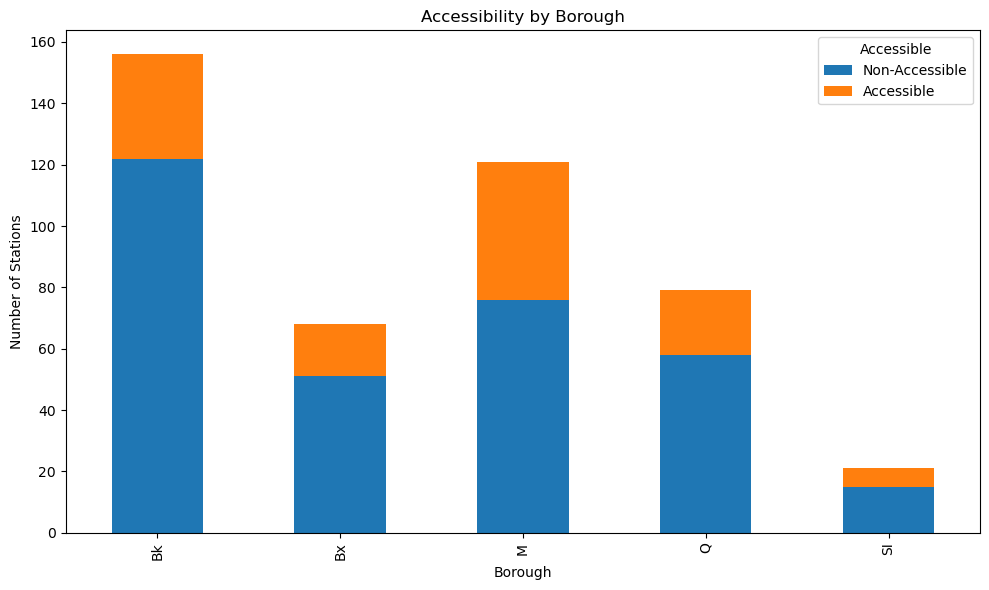

In [379]:
accessible_by_borough = df_stations[df_stations['ADA'] == 1].groupby('Borough').size().reset_index(name='Accessible Stations')
total_by_borough = df_stations.groupby('Borough').size().reset_index(name='Total Stations')

print(accessible_by_borough)
print(total_by_borough)

# Ensure ADA column is binary for accessibility (0 = not accessible, 1 = accessible)
df_stations['Accessible'] = df_stations['ADA'].apply(lambda x: 1 if x >= 1 else 0)

# Group data by Borough and count accessible and non-accessible stations
borough_accessibility = df_stations.groupby(['Borough', 'Accessible']).size().unstack(fill_value=0)

# Plot: Accessibility by Borough
borough_accessibility.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Accessibility by Borough")
plt.xlabel("Borough")
plt.ylabel("Number of Stations")
plt.legend(title="Accessible", labels=["Non-Accessible", "Accessible"])
plt.tight_layout()
plt.show()


In [380]:
df_stations['Daytime Routes'].unique()

array(['N W', 'N R W', 'N Q R W', 'R W', 'B Q R', 'R', 'D N R', 'N R',
       'B Q', 'B Q S', 'Q', 'F Q', 'D F N Q', 'D', 'N', 'J Z', 'J',
       'M J Z', 'M J', 'M', 'L', 'S', 'A', 'C', 'A C B D', 'C B', 'C E',
       'A C E', 'A C E B D F M', 'A C', 'A C G', 'A S', 'B D', 'F',
       'B D F M', 'F M', 'F G', 'E F', 'E F M R', 'M R', 'E M R', 'E M',
       'E B D', 'E J Z', 'E', 'G', '1', '1 2 3', '2 3', '2 3 4 5', '3',
       '3 4', '2 5', '6', '4', '4 5', '4 5 6', '2', '5', '7', '7 N W',
       'SIR', '1 2 3 L F M', '4 5 6 L N Q R W', '2 4 5', '4 B D', '1 A C',
       '7 E M G', 'B D F M N Q R W', 'F G R', '7 B D F M', '4 5 6 7 S',
       '1 2 3 7 A C E N Q R W S', '6 E M', '4 5 6 N R W', '1 A C B D',
       'D N', '7 E F M R', '2 3 4 5 B D N Q R', 'A C E L', '6 B D F M',
       '2 3 4 5 R', 'A C J Z L', '4 5 6 J Z', '6 J Z N Q R W',
       '2 3 A C E R W', 'F M J Z', '2 3 4 5 S', 'C S', '2 3 4 5 A C J Z',
       'G L', 'M L', '1 R W', 'A C F R'], dtype=object)

If you need use an accessible station, you will have a better chance taking Line A, E, and Q. Note that A goes to the airport.

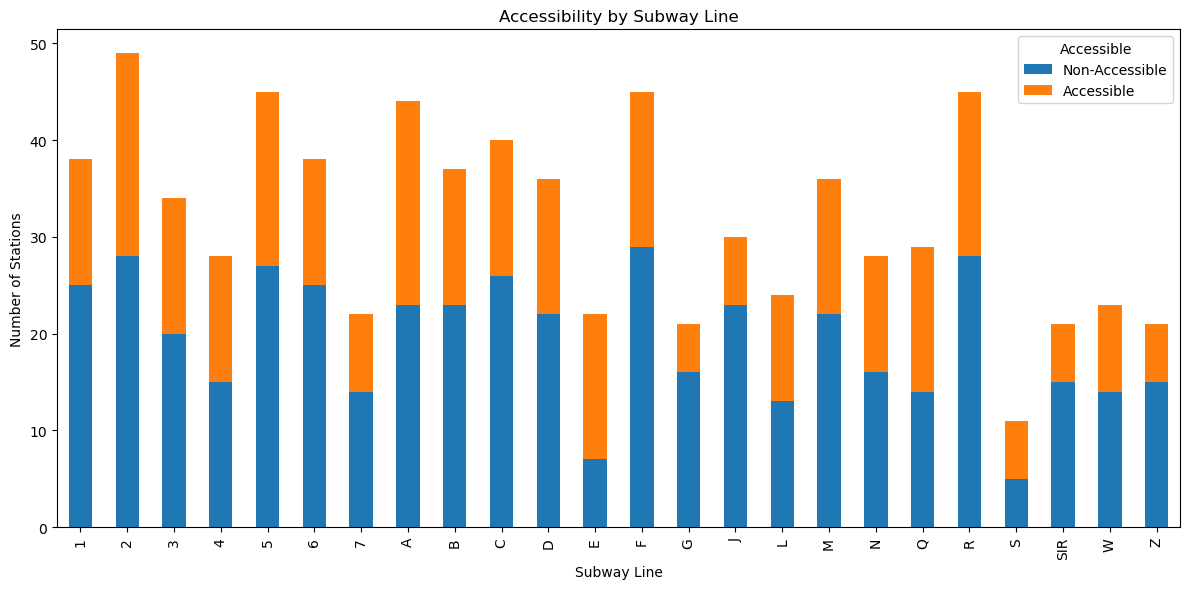

In [388]:
# Group data by Line and count accessible and non-accessible stations
df_stations['Lines'] = df_stations['Daytime Routes'].str.split()  # Split lines into a list
line_accessibility = df_stations.explode('Lines').groupby(['Lines', 'Accessible']).size().unstack(fill_value=0)
## if a cell has a list df.explode will transform the list into multiple rows 

# plot
line_accessibility.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Accessibility by Subway Line")
plt.xlabel("Subway Line")
plt.ylabel("Number of Stations")
plt.legend(title="Accessible", labels=["Non-Accessible", "Accessible"])
plt.tight_layout()
plt.show()

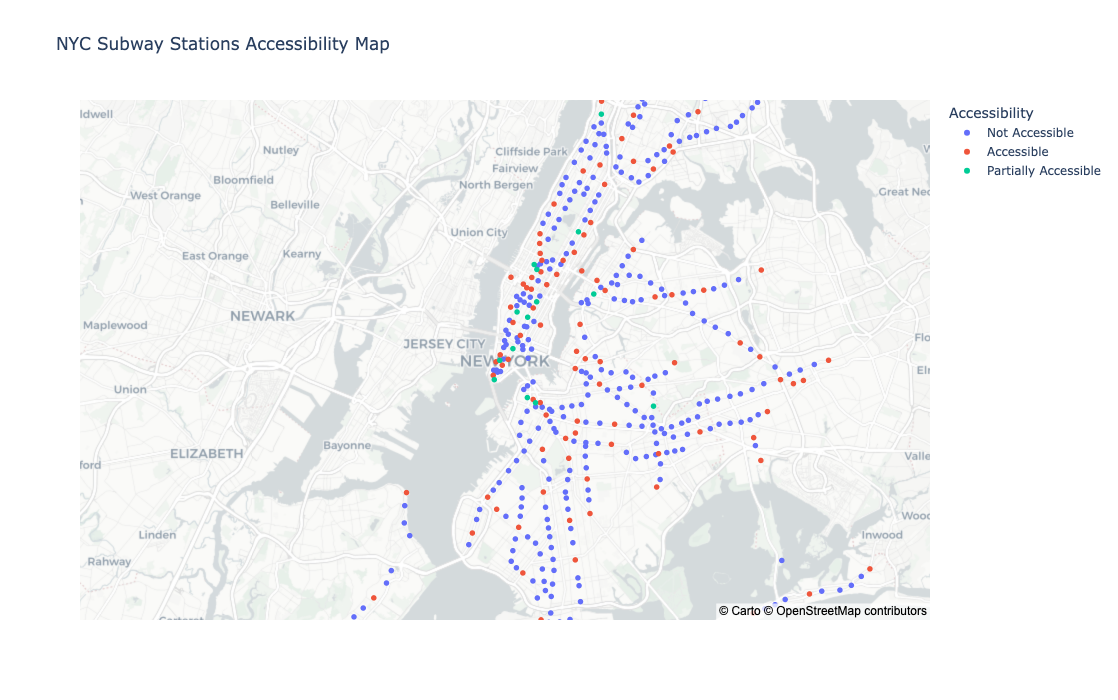

In [303]:
# map subway stations by accessibility status
def map_stations_by_accessibility(df):
    
    accessibility_mapping = {
        1: 'Accessible',
        2: 'Partially Accessible', ## accessible on one side
        0: 'Not Accessible'
    }
    df['Accessibility'] = df['ADA'].map(accessibility_mapping)

    fig = px.scatter_mapbox(
        df,
        lat='Latitude',
        lon='Longitude',
        color='Accessibility',
        hover_name='Display Name',
        hover_data=['Borough', 'Daytime Routes'],
        zoom=10,
        center={'lat': 40.7128, 'lon': -74.0060},
        mapbox_style='carto-positron',
        title='NYC Subway Stations Accessibility Map')

    fig.update_layout(height=700)
    fig.show()


map_stations_by_accessibility(df_stations)

## Part IV: Selecting Stations to Upgrade by Different Criteria
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; We implement our own interpretaion of MTA's selection criteria and decide if the station is in most urgent need of accessiblity upgrade from the following 4 angles: 

* **General Ridership Volume**: top 40% of most trafficked stations, either as a destination or origin of a subway trip, and their corresponding stations
* **Most Used by Population of Interest**: Top 60% of complexes of number of people using the disability or senior metro card
* **Coverage**: finding stations that reduces gaps in coverage by locating centriods of not accessible clusters in the geographic distance using k-means clustering
* **Demographics**: stations in the top 40% census tracts, with highest population with disabilities, aging population, age dedepency ratio, and public transportation need
  


Sources: 

https://new.mta.info/accessibility/selecting-subway-stations-for-upgrades 

In [165]:
stations_to_upgrade = []

#### 1. Working with Origin-Destination data, we want to find the top 40% stations where people get on the train as well as where people arrive in the entire city:

In [429]:
# calculate total ridership for each station complex
origin_ridership = pd.DataFrame(df_route_2024.groupby("Origin Station Complex ID")["Estimated Average Ridership"].sum())
destination_ridership = pd.DataFrame(df_route_2024.groupby("Destination Station Complex ID")["Estimated Average Ridership"].sum())

#ridership_total = origin_ridership.merge(destination_ridership, how = "inner",left_on = "Origin Station Complex ID", right_on = "Destination Station Complex ID")
# # merge the ridership data with the station data

df_stations_ridership = df_stations.merge(origin_ridership, how="right", left_on="Complex ID",right_on = "Origin Station Complex ID" )

df_stations_ridership_update = df_stations_ridership.merge(destination_ridership, how="right", left_on="Complex ID",right_on = "Destination Station Complex ID" )

df_stations_ridership_update.rename(columns={'Estimated Average Ridership_x':'Estimated Average Ridership Origin', 'Estimated Average Ridership_y':'Estimated Average Ridership Destination'}, inplace=True)

df_stations_ridership_update.head(10)

Complex ID  Is Complex  Number Of Stations In Complex  \
0           1       False                              1   
1           2       False                              1   
2           3       False                              1   
3           4       False                              1   
4           5       False                              1   
5           6       False                              1   
6           8       False                              1   
7           9       False                              1   
8          10       False                              1   
9          13       False                              1   

              Stop Name                Display Name Constituent Station Names  \
0  Astoria-Ditmars Blvd  Astoria-Ditmars Blvd (N W)      Astoria-Ditmars Blvd   
1          Astoria Blvd          Astoria Blvd (N W)              Astoria Blvd   
2                 30 Av                 30 Av (N W)                     30 Av   
3              Broadway              Broadway (N W)                  Broadway   
4                 36 Av                 36 Av (N W)                     36 Av   
5     39 Av-Dutch Kills     39 Av-Dutch Kills (N W)         39 Av-Dutch Kills   
6            5 Av/59 St          5 Av/59 St (N R W)                5 Av/59 St   
7            57 St-7 Av        57 St-7 Av (N Q R W)                57 St-7 Av   
8                 49 St               49 St (N R W)                     49 St   
9                 28 St                 28 St (R W)                     28 St   

  Station IDs GTFS Stop IDs Borough    CBD  ...   Latitude  Longitude  ADA  \
0           1           R01       Q  False  ...  40.775036 -73.912034    0   
1           2           R03       Q  False  ...  40.770258 -73.917843    1   
2           3           R04       Q  False  ...  40.766779 -73.921479    0   
3           4           R05       Q  False  ...  40.761820 -73.925508    0   
4           5           R06       Q  False  ...  40.756804 -73.929575    0   
5           6           R08       Q  False  ...  40.752882 -73.932755    0   
6           8           R13       M   True  ...  40.764811 -73.973347    0   
7           9           R14       M   True  ...  40.764664 -73.980658    1   
8          10           R15       M   True  ...  40.759901 -73.984139    2   
9          13           R18       M   True  ...  40.745494 -73.988691    0   

     ADA Notes  CensusTract         Accessibility  Accessible         Lines  \
0          NaN  36081011500        Not Accessible           0        [N, W]   
1          NaN  36081012500            Accessible           1        [N, W]   
2          NaN  36081006300        Not Accessible           0        [N, W]   
3          NaN  36081005900        Not Accessible           0        [N, W]   
4          NaN  36081005300        Not Accessible           0        [N, W]   
5          NaN  36081003100        Not Accessible           0        [N, W]   
6          NaN  36061014300        Not Accessible           0     [N, R, W]   
7          NaN  36061013700            Accessible           1  [N, Q, R, W]   
8  Uptown only  36061012500  Partially Accessible           1     [N, R, W]   
9          NaN  36061007600        Not Accessible           0        [R, W]   

   Estimated Average Ridership Origin Estimated Average Ridership Destination  
0                        5.016052e+05                            4.914699e+05  
1                        3.655590e+05                            3.575548e+05  
2                        4.548943e+05                            4.506590e+05  
3                        4.152429e+05                            4.141505e+05  
4                        2.227972e+05                            2.244794e+05  
5                        1.324218e+05                            1.357021e+05  
6                        5.520736e+05                            5.851106e+05  
7                        1.235246e+06                            1.317850e+06  
8

In [140]:
# get stations with disability ridership in the top 40%
top_40_origin = df_stations_ridership_update[df_stations_ridership_update['Estimated Average Ridership Origin'] > df_stations_ridership_update['Estimated Average Ridership Origin'].quantile(0.6)]
top_40_dest = df_stations_ridership_update[df_stations_ridership_update['Estimated Average Ridership Destination'] > df_stations_ridership_update['Estimated Average Ridership Destination'].quantile(0.6)]



In [535]:
print(len(top_40_origin[top_40_origin['ADA'] == 0]))#/len(top_40_origin))
#print(len(top_40_dest[top_40_dest['ADA'] == 1])/len(top_40_dest))

91


In [167]:
# add non ada stations to the upgrade list
# top_40_origintop_40_origin[top_40_origin['ADA']==0]
top_40_list = [top_40_origin[top_40_origin['ADA'] == 0]['GTFS Stop IDs']]
top_40_list.append(top_40_dest[top_40_dest['ADA'] == 0]['GTFS Stop IDs'])
top_40_list = np.concatenate(top_40_list)



stations_to_upgrade.append(np.array(separated_values_final))

#### 2. We want to find which stations are used the most by people with disability or seniors, by looking at the type of metro card they use.

In [122]:
# calculate ridership for each complex
df_ridership_dis_agg = df_ridership_dis.groupby(['station_complex_id', 'borough'],as_index=False)['ridership'].sum()
df_entrance_exi_ridership_dis = df_ridership_dis_agg.merge(df_entrance_exit, how = 'right',left_on = 'station_complex_id', right_on = 'complex_id')
df_entrance_exi_ridership_dis['ridership'].describe() 
# check if any station doesnt have data 

count      1000.000000
mean      89488.705000
std      112531.227129
min        3526.000000
25%       24851.000000
50%       48671.000000
75%      108454.000000
max      620931.000000
Name: ridership, dtype: float64

In [116]:
# only keep the station id 
df_entrance_exi_ridership_dis_unique = df_entrance_exi_ridership_dis.drop_duplicates(subset='gtfs_stop_id', keep='first') 
# get stations with disability ridership in the top 60%
top_60_df = df_entrance_exi_ridership_dis_unique[df_entrance_exi_ridership_dis_unique['ridership'] > df_entrance_exi_ridership_dis_unique['ridership'].quantile(0.4)]

In [168]:
stations_to_upgrade.append(top_60_df['gtfs_stop_id'].values)

In [546]:
print(top_60_df['entrance_type'].value_counts())
print(len(top_60_df['entrance_type']))

entrance_type
Stair                 89
Easement - Street     13
Station House         12
Escalator              3
Easement - Passage     2
Elevator               1
Name: count, dtype: int64
120


In [169]:
stations_to_upgrade

[array(['R01', 'R04', 'R05', 'R13', 'R18', 'R19', 'R21', 'R22', 'R36',
        'D25', 'D28', 'D31', 'D39', 'D40', 'M11', 'L11', 'L15', 'L16',
        'A12', 'D13', 'A19', 'A20', 'A21', 'A22', 'A30', 'A33', 'A34',
        'A40', 'A42', 'A46', 'B10', 'D18', 'D22', 'F14', 'F16', 'F18',
        'F20', 'F21', 'G10', 'G11', 'G12', 'G13', 'G19', 'F12', 'D14',
        'G28', 'G33', '111', '113', '114', '115', '116', '117', '118',
        '119', '121', '122', '126', '129', '130', '133', '134', '230',
        '234', '608', '409', '622', '623', '624', '625', '627', '628',
        '632', '636', '638', '419', '225', '702', '706', '708', '709',
        '714', '715', '718', 'R09', '721', '222', '415', 'F23', 'R33',
        '724', 'D16', '629', 'R11', 'A51', 'J27', 'L22', 'F15', 'M18',
        '239', 'S04', 'R01', 'R04', 'R05', 'R13', 'R18', 'R19', 'R21',
        'R22', 'R36', 'D25', 'D28', 'D31', 'D39', 'D40', 'M11', 'L11',
        'L15', 'L16', 'A12', 'D13', 'A19', 'A20', 'A21', 'A22', 'A30',
      

In [460]:
### save output data

## merge ridership to stations 
temp1 = df_stations_ridership_update[['GTFS Stop IDs', 'Estimated Average Ridership Origin', 'Estimated Average Ridership Destination']]
temp2 = df_entrance_exi_ridership_dis_unique[['gtfs_stop_id','ridership']]
df_with_census_demographics_update = df_with_census_demographics.merge(temp1, how = 'left', right_on = 'GTFS Stop IDs', left_on = 'GTFS Stop IDs')
df_with_census_demographics_update_final = df_with_census_demographics_update.merge(temp2, how = 'left', right_on = 'gtfs_stop_id', left_on = 'GTFS Stop IDs')
df_with_census_demographics_update_final.rename({'ridership': 'Senior Disa Ridership'}, axis = 1, inplace = True)

df_with_census_demographics_update_final.to_csv('ridership_demo_final.csv')

In [461]:
df_with_census_demographics_update_final.columns

Index(['Complex ID', 'Is Complex', 'Number Of Stations In Complex',
       'Stop Name', 'Display Name', 'Constituent Station Names', 'Station IDs',
       'GTFS Stop IDs', 'Borough', 'CBD', 'Daytime Routes', 'Structure Type',
       'Latitude', 'Longitude', 'ADA', 'ADA Notes', 'CensusTract',
       'Total population for whom disability status is determined',
       'Total population with a disability',
       'Population 18–64 years with a disability',
       'Population 65 years and over with a disability',
       'Employed population with a disability (18–64)', 'Total population',
       'Population 55-59', 'Population 60-64', 'Population 65 and over',
       'Age Dependency Ratio', 'Total workers 16 years and over',
       'Car, truck, or van - drove alone',
       'Public transportation (excluding taxicab)', 'Median household income',
       'Mean household income', 'Percentage of households below poverty level',
       'Percentage of households with income over $200k', 'state', 'c

In [510]:
df_corr['Public transportation (excluding taxicab)']

0      2.7
1      3.2
2      3.6
3      1.7
4      2.0
      ... 
440    0.6
441    2.7
442    1.0
443    2.7
444    0.5
Name: Public transportation (excluding taxicab), Length: 445, dtype: float64

Total population                                           int64
Median age                                               float64
Population 55-59                                         float64
Population 60-64                                         float64
Population 65 and over                                     int64
Total population with a disability                         int64
Population 18–64 years with a disability                   int64
Population 65 years and over with a disability             int64
Employed population with a disability (18–64)            float64
Age Dependency Ratio                                     float64
Total workers 16 years and over                            int64
Workers 16 years and over using public transportation      int64
Public transportation (excluding taxicab)                float64
Median household income                                    int64
Percentage of households below poverty level             float64
Percentage of households 

/var/folders/qv/1bnh64t16cnc1ftltf9q3y6c0000gn/T/ipykernel_39539/1442286266.py:17: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



Text(0.5, 1.0, 'Features Correlation Matrix')

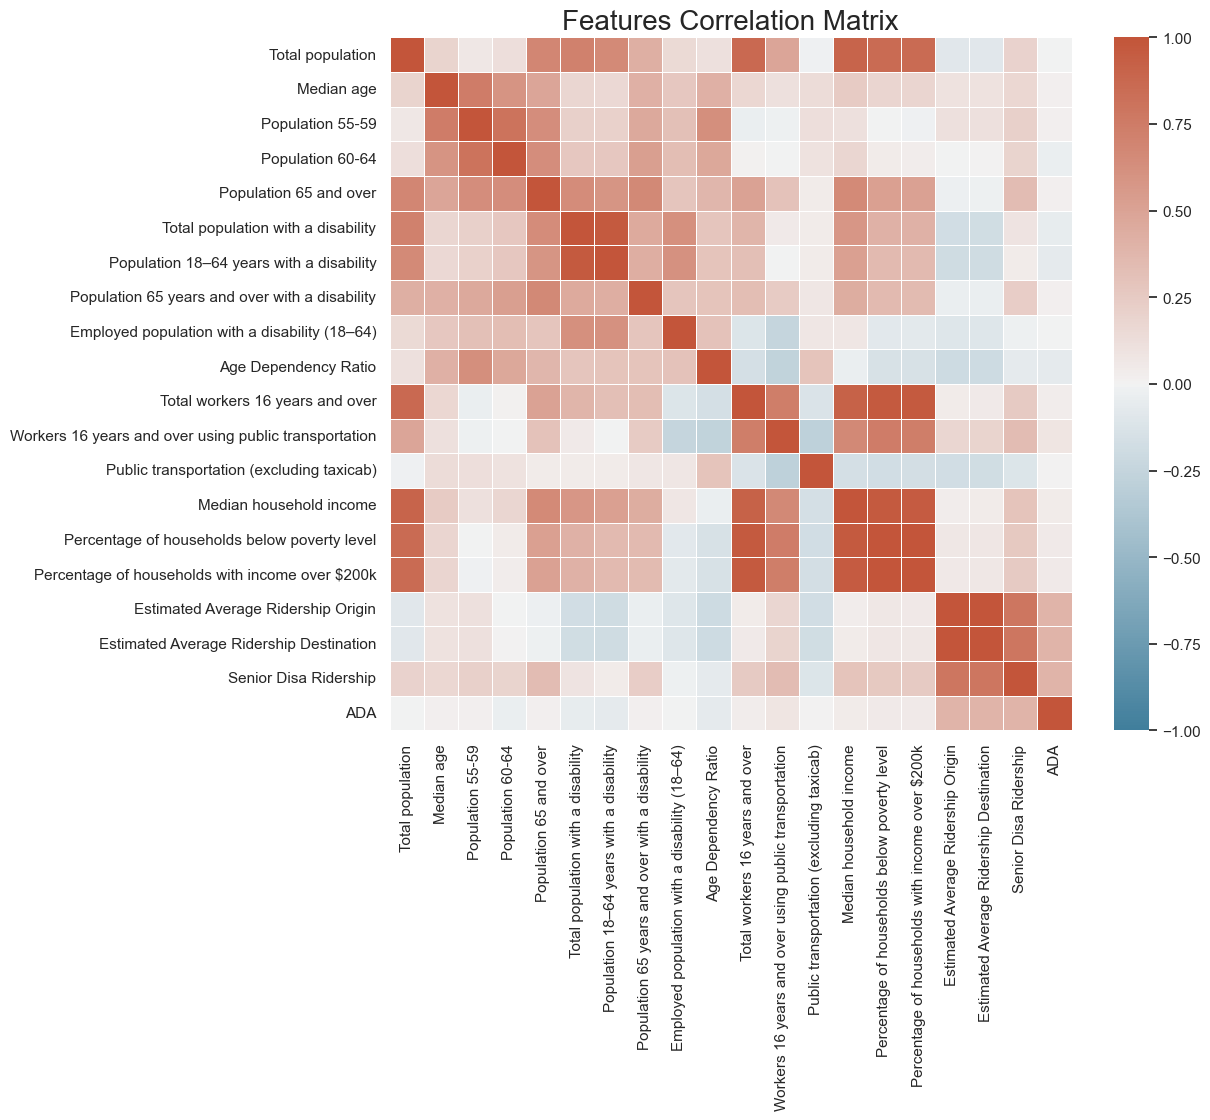

In [555]:
df_corr = df_with_census_demographics_update_final[['Total population', 'Median age','Population 55-59', 'Population 60-64', 'Population 65 and over',
       'Total population with a disability',
       'Population 18–64 years with a disability',
       'Population 65 years and over with a disability',
       'Employed population with a disability (18–64)', 
       'Age Dependency Ratio', 'Total workers 16 years and over','Workers 16 years and over using public transportation',
       'Public transportation (excluding taxicab)', 'Median household income',
       'Percentage of households below poverty level',
       'Percentage of households with income over $200k',
       'Estimated Average Ridership Origin',
       'Estimated Average Ridership Destination', 'Senior Disa Ridership','ADA']]

# drop duplicates 
df_corr = df_corr.loc[:, ~df_corr.columns.duplicated()]
df_corr.astype(float)
print(df_corr.dtypes)
df_corr.loc[df_corr['ADA'] == 2, 'ADA'] = float(0.5)
# print(df_corr['Public transportation (excluding taxicab)'].describe())


## map all the ADA = 2, partially accessible, to 0.5


# Compute the correlation matrix
corr = df_corr.corr()

# # lower triangle matrix
# mask = np.tril(np.ones_like(corr, dtype=bool))
# upper_triangle = corr.where(mask)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))



# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, 
            #annot=True,  # Annotate each cell with its correlation coefficient
            cmap=cmap,  # Choose a color map (e.g., 'coolwarm', 'viridis')
            fmt=".2f",  # Format the numbers inside the cells
            linewidths=0.5,  # Add lines between cells
            vmin=-1,  # Minimum value of the color bar
            vmax=1, 
            cbar=True)  # Add a color bar

ax.set_title('Features Correlation Matrix', size=20)


#### 3. To ensure accessible stations coverage enough of the area in each borough, we will find clusters among the unaccessible stations. We choose to apply K-means clustering by borough to account for stations with physical boundaries in between that are hard to cross but close in distance. 

In [556]:
def perform_kmeans(df, n_clusters=15):
    """
    Performs KMeans clustering, appends cluster labels to the DataFrame,
    and identifies the nearest data point to the centroids

    Input:
        df with  'Latitude' and 'Longitude'
        n_clusters int number of clusters 

    Output:
        tuple: 
            - Updated DataFrame with cluster labels.
            - List of indices of the nearest data points to the centroids.
    """
    coords = df[['Latitude', 'Longitude']].to_numpy()

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=47)
    kmeans.fit(coords)

    # Append cluster labels to DataFrame
    df = df.copy()
    df['cluster_label'] = kmeans.labels_

    # Find the nearest data point to each cluster center
    centroid_indices = []
    for center in kmeans.cluster_centers_:
        distances = distance.cdist([center], coords, 'euclidean')
        closest_point_idx = np.argmin(distances)
        centroid_indices.append(df.index[closest_point_idx])  # Store the original index

    return df, centroid_indices


def plot_clusters_with_labels(df, centroid_indices):
    """
    plots KMeans clusters and centroids on a scatterplot

    Input:
         df containing 'Latitude', 'Longitude', and 'cluster_label'(output from perform_k_means)
         list of centroid_indices to highlight(output from perform_k_means)
    Output:
        plot.show
    """
    plt.figure(figsize=(10, 8))

    # Plot clusters
    sns.scatterplot(
        x=df['Longitude'], 
        y=df['Latitude'], 
        hue=df['cluster_label'], 
        legend=False)

    # Highlight centroids
    centroid_coords = df.loc[centroid_indices, ['Latitude', 'Longitude']].to_numpy()
    plt.scatter(
        centroid_coords[:, 1], 
        centroid_coords[:, 0], 
        s=200, c='black', marker='X', label='Centroids')

    plt.title("Clusters with Centroids")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.show()


In [563]:
def find_optimal_k(df, max_k=20):
    """
    Uses the elbow method to find the optimal number of clusters.

    Input:
        df containing 'Latitude' and 'Longitude'.
        max_k (int): Maximum number of clusters to test.

    Output:
        elbow plot
    """
    coords = df[['Latitude', 'Longitude']].to_numpy()
    inertia = []

    # Calculate inertia for each k from 1 to max_k
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(coords)
        inertia.append(kmeans.inertia_)

    # Plot the inertia for different k values
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), inertia, marker='o', linestyle='--')
    plt.title('Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Distances (Inertia)')
    plt.xticks(range(1, max_k + 1))
    plt.grid()
    plt.show()



In [53]:
# split the data into accessible and not accessible
not_accessible = df_stations[df_stations['ADA'] == 0]
accessible = df_stations[df_stations['ADA'] != 0]
boroughs = not_accessible['Borough'].unique()
centroid_indices = {}


not_accessible_queens = not_accessible[not_accessible['Borough'] == 'Q']
not_accessible_brook = not_accessible[not_accessible['Borough'] == 'Bk']
not_accessible_bronx = not_accessible[not_accessible['Borough'] == 'Bx']
not_accessible_man = not_accessible[not_accessible['Borough'] == 'M']
not_accessible_si = not_accessible[not_accessible['Borough'] == 'SI']

Manhattan


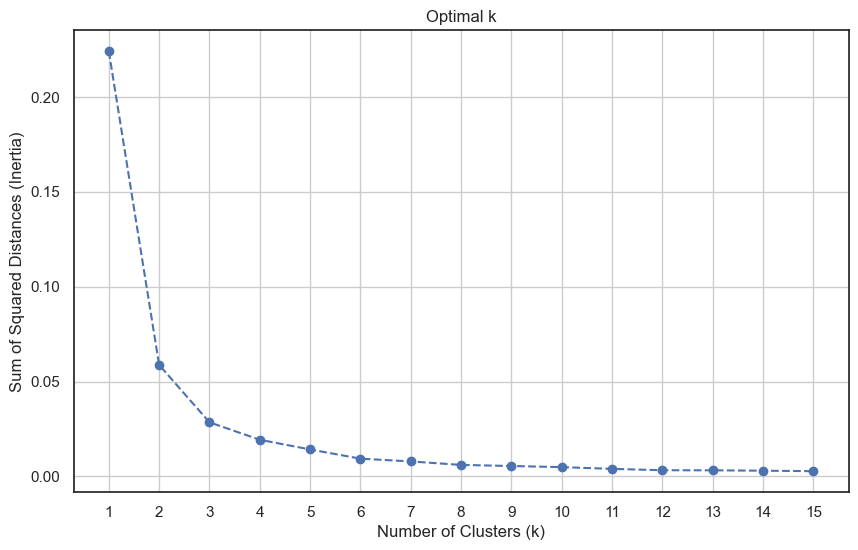

Brooklyn


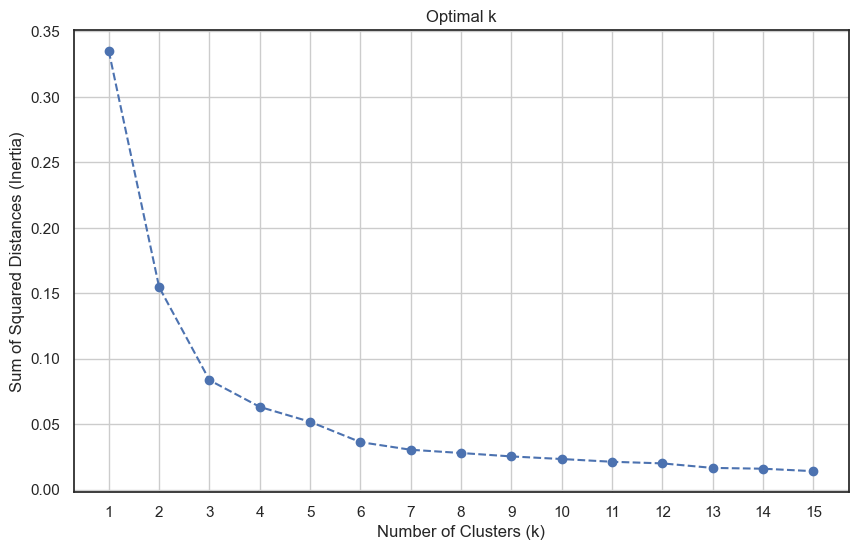

Queens


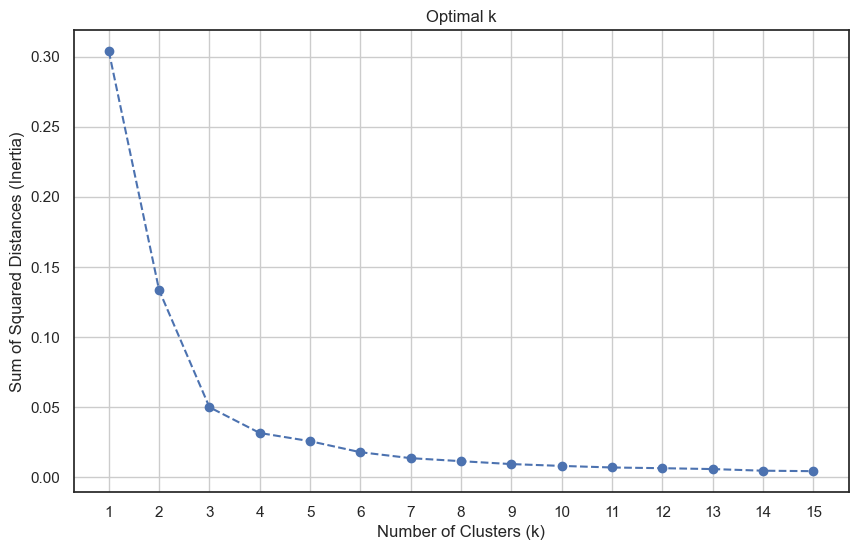

Bronx


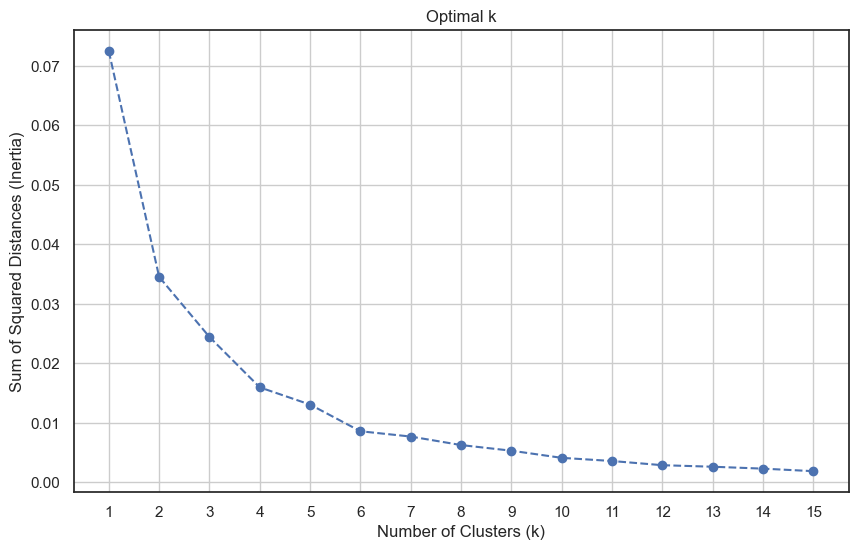

Staten Island


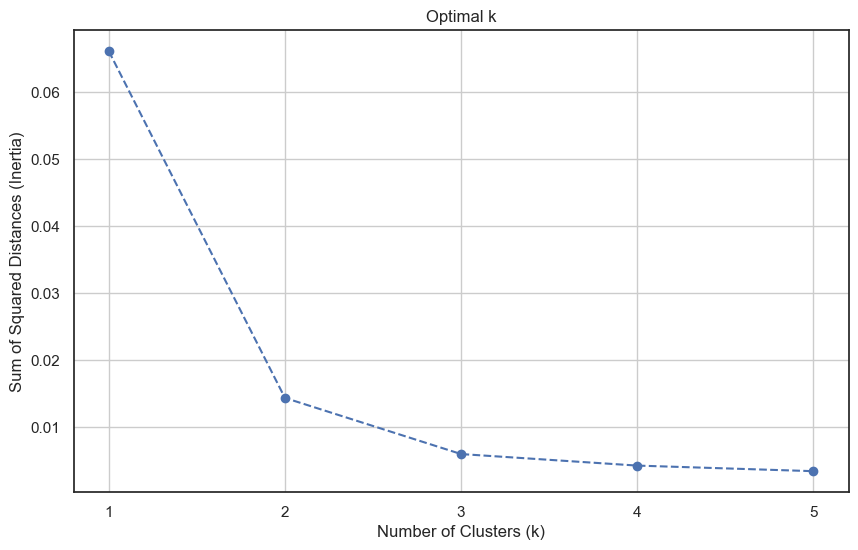

In [565]:
## use elbow 
print("Manhattan")
find_optimal_k(not_accessible_man, max_k=15)
print("Brooklyn")
find_optimal_k(not_accessible_brook, max_k=15)
print("Queens")
find_optimal_k(not_accessible_queens, max_k=15)
print("Bronx")
find_optimal_k(not_accessible_bronx, max_k=15)
print("Staten Island")
find_optimal_k(not_accessible_si, max_k=5)

Reason for not using elbow - k, or the number of new accessible stations, 
* a) in practice would be set and constrained by the budget, and
* b) ideally we want as many ADA stations as possible. <br/>
So here we assume we are upgrading 10 more of the unaccessible stations for all boroughs, and 5 more for SI. </br>
After finding the centriods, we find the nearest station to them and mark them below.

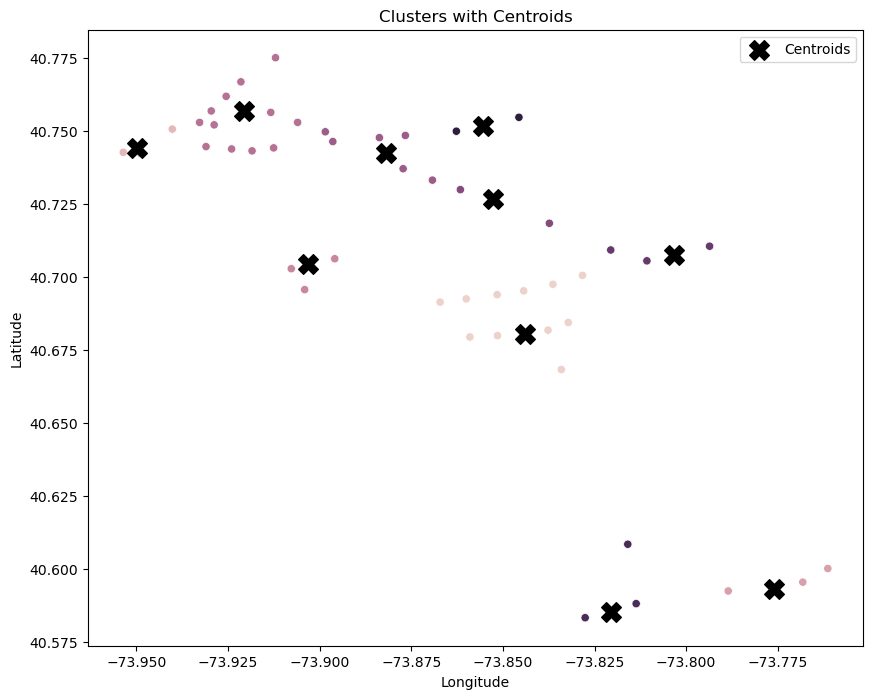

In [55]:
not_accessible_queens_k_means, centroid_indices['Q'] = perform_kmeans(not_accessible_queens, n_clusters=10)
plot_clusters_with_labels(not_accessible_queens_k_means, centroid_indices['Q'])


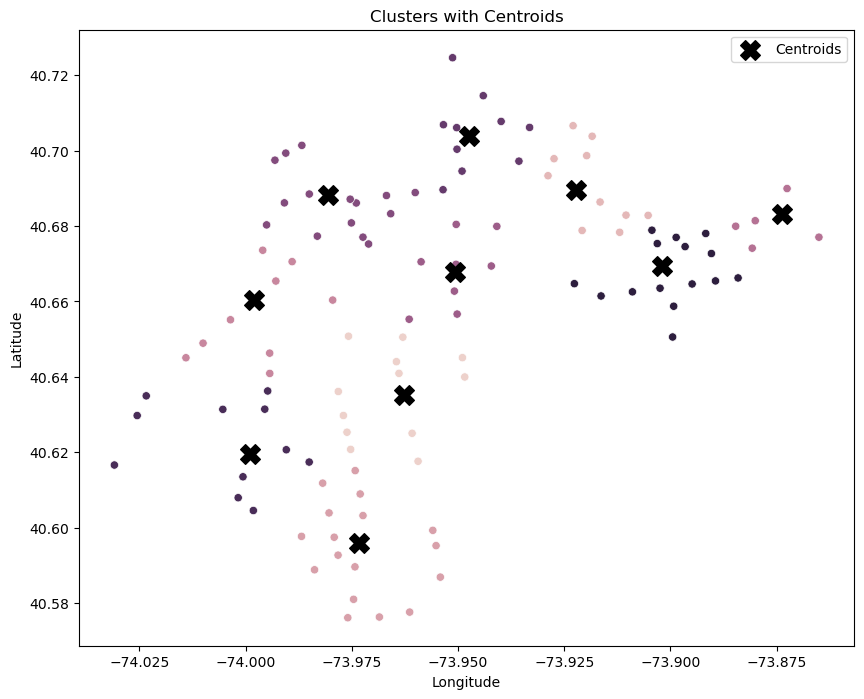

In [65]:
not_accessible_bk_k_means, centroid_indices['Bk'] = perform_kmeans(not_accessible_brook, n_clusters=10)
plot_clusters_with_labels(not_accessible_bk_k_means, centroid_indices['Bk'])


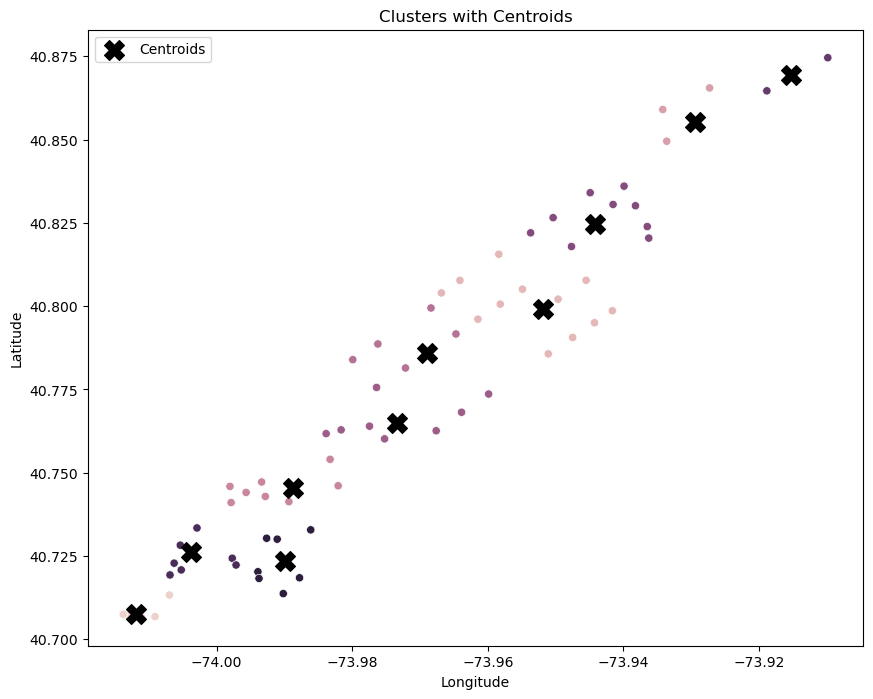

In [366]:
not_accessible_man_k_means, centroid_indices['M'] = perform_kmeans(not_accessible_man, n_clusters=10)
plot_clusters_with_labels(not_accessible_man_k_means, centroid_indices['M'])


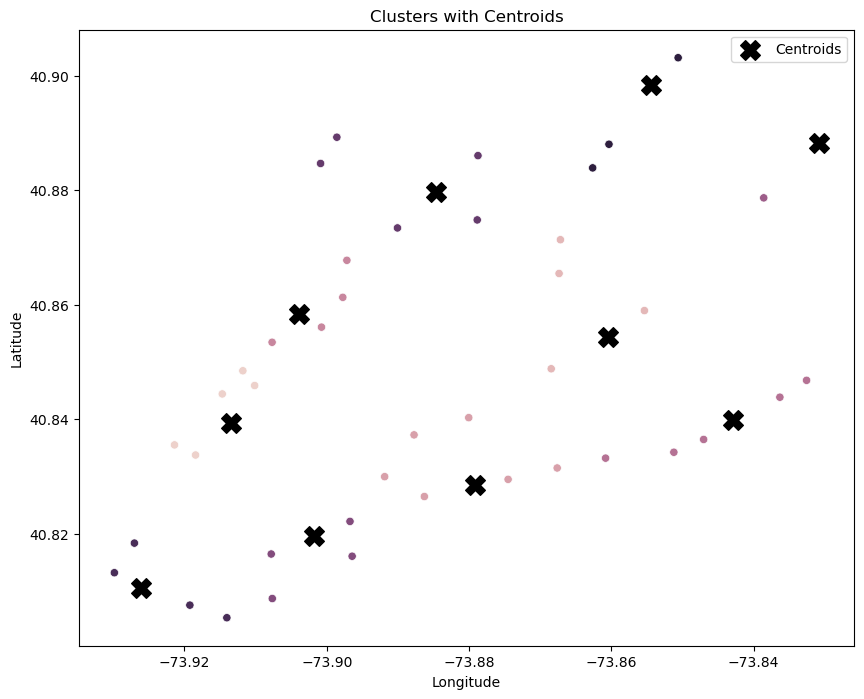

In [67]:
not_accessible_bx_k_means, centroid_indices['Bx'] = perform_kmeans(not_accessible_bronx, n_clusters=10)
plot_clusters_with_labels(not_accessible_bx_k_means, centroid_indices['Bx'])



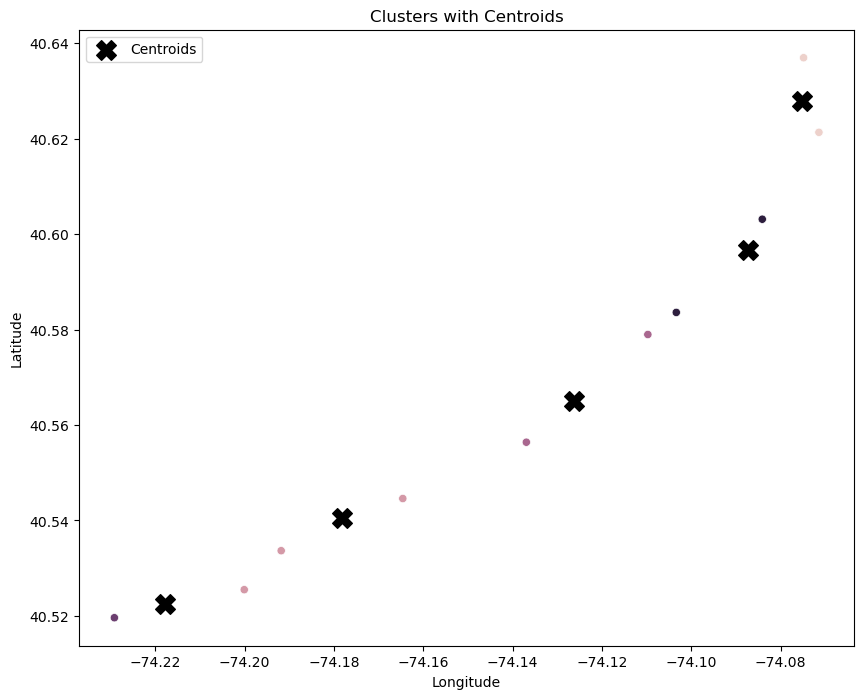

In [76]:
not_accessible_si_k_means, centroid_indices['SI'] = perform_kmeans(not_accessible_si, n_clusters=5)
plot_clusters_with_labels(not_accessible_si_k_means, centroid_indices['SI'])


In [170]:
## store these staions to the upgrade list
stations_to_upgrade.append(not_accessible_queens.loc[centroid_indices['Q'],'GTFS Stop IDs'].values)
stations_to_upgrade.append(not_accessible_brook.loc[centroid_indices['Bk'],'GTFS Stop IDs'].values)
stations_to_upgrade.append(not_accessible_man.loc[centroid_indices['M'],'GTFS Stop IDs'].values)
stations_to_upgrade.append(not_accessible_bronx.loc[centroid_indices['Bx'],'GTFS Stop IDs'].values)
stations_to_upgrade.append(not_accessible_si.loc[centroid_indices['SI'],'GTFS Stop IDs'].values)


#### 4. Explore demographic information for census tracts stations are located in.

In [317]:
print(df_with_census_demographics.columns)
df.columns.duplicated()

Index(['Complex ID', 'Is Complex', 'Number Of Stations In Complex',
       'Stop Name', 'Display Name', 'Constituent Station Names', 'Station IDs',
       'GTFS Stop IDs', 'Borough', 'CBD', 'Daytime Routes', 'Structure Type',
       'Latitude', 'Longitude', 'ADA', 'ADA Notes', 'CensusTract',
       'Total population for whom disability status is determined',
       'Total population with a disability',
       'Population 18–64 years with a disability',
       'Population 65 years and over with a disability',
       'Employed population with a disability (18–64)', 'Total population',
       'Population 55-59', 'Population 60-64', 'Population 65 and over',
       'Age Dependency Ratio', 'Total workers 16 years and over',
       'Car, truck, or van - drove alone',
       'Public transportation (excluding taxicab)', 'Median household income',
       'Mean household income', 'Percentage of households below poverty level',
       'Percentage of households with income over $200k', 'state', 'c

array([False, False, False])

In [328]:
# get top stations with disability
top_20_percent_dis = df_with_census_demographics['Total population with a disability'].quantile(0.8)
top_20_df_dis = df_with_census_demographics[df_with_census_demographics['Total population with a disability'] >= top_20_percent_dis]

top_20_percent_age = df_with_census_demographics['Age Dependency Ratio'].quantile(0.8)
top_20_df_age = df_with_census_demographics[df_with_census_demographics['Age Dependency Ratio'] >= top_20_percent_age]

top_20_percent_age = df_with_census_demographics['Age Dependency Ratio'].quantile(0.8)
top_20_df_age = df_with_census_demographics[df_with_census_demographics['Age Dependency Ratio'] >= top_20_percent_age]


# top_20_percent = df_with_census_demographics.iloc[:, 18:26].quantile(0.8)
# # Create an empty list to store indexes
# top_20 = []

# # Loop through columns 18-26
# for col in df_with_census_demographics.columns[18:26]:
#     top_20_col = df_with_census_demographics[df_with_census_demographics[col] >= top_20_percent[col]]
    
#     # Append the indexes to the main list
#     top_20.append(top_20_col)

In [552]:
len(top_20_df_dis[top_20_df_dis['ADA'] == 0])/len(top_20_df_dis['ADA'])
top_20_df_age[top_20_df_age['ADA'] == 0].count()

Complex ID                                                   68
Is Complex                                                   68
Number Of Stations In Complex                                68
Stop Name                                                    68
Display Name                                                 68
Constituent Station Names                                    68
Station IDs                                                  68
GTFS Stop IDs                                                68
Borough                                                      68
CBD                                                          68
Daytime Routes                                               68
Structure Type                                               68
Latitude                                                     68
Longitude                                                    68
ADA                                                          68
ADA Notes                               

In [330]:
stations_to_upgrade.append(top_20_df_dis.loc[top_20_df_dis['ADA'] == 0,'GTFS Stop IDs'].values)
stations_to_upgrade.append(top_20_df_age.loc[top_20_df_age['ADA'] == 0,'GTFS Stop IDs'].values)

In [331]:
np.concatenate(stations_to_upgrade)

array(['R01', 'R04', 'R05', 'R13', 'R18', 'R19', 'R21', 'R22', 'R36',
       'D25', 'D28', 'D31', 'D39', 'D40', 'M11', 'L11', 'L15', 'L16',
       'A12', 'D13', 'A19', 'A20', 'A21', 'A22', 'A30', 'A33', 'A34',
       'A40', 'A42', 'A46', 'B10', 'D18', 'D22', 'F14', 'F16', 'F18',
       'F20', 'F21', 'G10', 'G11', 'G12', 'G13', 'G19', 'F12', 'D14',
       'G28', 'G33', '111', '113', '114', '115', '116', '117', '118',
       '119', '121', '122', '126', '129', '130', '133', '134', '230',
       '234', '608', '409', '622', '623', '624', '625', '627', '628',
       '632', '636', '638', '419', '225', '702', '706', '708', '709',
       '714', '715', '718', 'R09', '721', '222', '415', 'F23', 'R33',
       '724', 'D16', '629', 'R11', 'A51', 'J27', 'L22', 'F15', 'M18',
       '239', 'S04', 'R01', 'R04', 'R05', 'R13', 'R18', 'R19', 'R21',
       'R22', 'R36', 'D25', 'D28', 'D31', 'D39', 'D40', 'M11', 'L11',
       'L15', 'L16', 'A12', 'D13', 'A19', 'A20', 'A21', 'A22', 'A30',
       'A33', 'A34',

In [342]:
# need to clean the list, since some complexes have more than one stations 
stations_to_upgrade = np.concatenate(stations_to_upgrade)
stations_to_upgrade_final = []

for item in stations_to_upgrade:
    # Split by ';' if present
    stations_to_upgrade_final.extend([x.strip() for x in str(item).split(';')])
    

In [352]:
df_final_list = pd.DataFrame(set(stations_to_upgrade_final))
df_final_list.columns = ['id']
## since list doesnt have .unique function


In [370]:
## match back to station
df_output = df_final_list.merge(df_stations, how = 'inner',left_on = 'id', right_on = 'GTFS Stop IDs')
df_output = df_output[df_output['ADA'] == 0]
df_output.to_csv("output_stations.csv")

## Exploratory Code Not Used

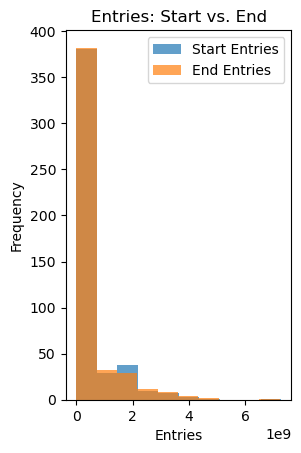

In [113]:
# ARCHIVED DATASET #https://data.ny.gov/Transportation/MTA-Subway-Turnstile-Usage-Data-2022/k7j9-jnct/about_data (API default 1000/call, ~11M rows) most recent 2022
response_turnstile = requests.get("https://data.ny.gov/resource/k7j9-jnct.csv", "$limit=80000000")
df_turnstile_2022 = pd.read_csv(StringIO(response_turnstile.text))

df_turnstile_2022.to_csv('turnstile_2022.csv')
df_turnstile_2022 = pd.read_csv('turnstile_2022.csv')

print(len(df_turnstile_2022['c_a'].unique())) 
print(len(df_turnstile_2022['unit'].unique())) ## unit column has the stations 
print(df_turnstile_2022.head(10))
df_turnstile_2022.tail(12)

df_turnstile_2022_agg = df_turnstile_2022.groupby(['unit', 'datetime'])[['entries','exits']].sum().reset_index()
# df_turnstile_2022_agg['annual_entries'] = df_turnstile_2022.loc[df_turnstile_2022['datetime']=='2022-12-30 23:59:31', ['unit','datetime','entries']].groupby('unit').sum()['entries'] - df_turnstile_2022.loc[df_turnstile_2022['datetime']=='2022-01-01 00:00:00', ['unit','datetime','entries']].groupby('unit').sum()['entries']
# df_turnstile_2022_agg['annual_exits'] = df_turnstile_2022.loc[df_turnstile_2022['datetime']=='2022-12-30 23:59:31', ['unit','datetime','exits']].groupby('unit').sum()['exits'] - df_turnstile_2022.loc[df_turnstile_2022['datetime']=='2022-01-01 00:00:00', ['unit','datetime','exits']].groupby('unit').sum()['exits']
df_turnstile_2022_agg_annual = pd.DataFrame()

df_turnstile_2022['datetime'] = pd.to_datetime(df_turnstile_2022['date'].str.replace("T", " ") + " " + df_turnstile_2022['time'])

# some of the annual values returns NaN, turns out the first and last timestap for each unit are not all the same
# get first and last row for each unit
first_rows = df_turnstile_2022_agg.loc[df_turnstile_2022_agg.groupby('unit')['datetime'].idxmin()]
last_rows = df_turnstile_2022_agg.loc[df_turnstile_2022_agg.groupby('unit')['datetime'].idxmax()]
df_turnstile_2022_agg_annual = first_rows[['unit']].copy()
df_turnstile_2022_agg_annual['annual_entries'] = last_rows['entries'].values - first_rows['entries'].values
df_turnstile_2022_agg_annual['annual_exits'] = last_rows['exits'].values - first_rows['exits'].values

plt.subplot(1, 2, 1)
plt.hist(first_rows['entries'], bins=10, alpha=0.7, label='Start Entries')
plt.hist(last_rows['entries'], bins=10, alpha=0.7, label='End Entries')
plt.title('Entries: Start vs. End')
plt.xlabel('Entries')
plt.ylabel('Frequency')
plt.legend()